## BME i9400
## Fall 2025

### Homework 2: Logistic Regression with L1 and L2 Regularization

**Assigned:** 2025-11-10  
**Due:** 2025-11-24 11:59:59.999 PM EST

**Place completed notebook into your "my-work" folder on JupyterHub**

**Honor & AI use policy (read carefully)**
- You may use docs/StackOverflow for syntax.  
- You **may** ask an LLM for debugging/snippets, but you must include an **AI Log** at the end (prompts + what you used).
- You **may not** ask for a full solution. Your code and plots must reflect your own understanding.

**Deliverables**
1. Executed notebook (.ipynb) with all cells run. 
2. `ai_log.md` (if you used an LLM).

### Student Starter Notebook 

This notebook walks you step-by-step through the assignment.

**Dataset assumptions:**
- File: `diabetes.csv` (provided on GitHub)
- Target column: `Outcome` (1 = diabetes, 0 = no diabetes)
- All other columns are numeric predictors.

**Instructions:**
- Read the markdown **before** each code cell.
- Fill in any `TODO` sections in the code.
- Answer the short written questions in the markdown blocks.
- Run cells in order so variables are defined correctly.

Do **not** remove cells; add new ones if you want extra exploration.


---
## 1. Setup & Imports

Import all necessary libraries and set up basic plotting defaults.
Run this cell first. No edits needed unless you add extra packages.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    classification_report,
)

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['font.size'] = 11

---
## 2. Task 1 – Data Loading & Basic Exploration (10 pts)

**Goal:** Load the dataset and understand what you are modeling.

### Instructions
- Load `diabetes.csv` into a DataFrame called `df`.
- Separate features `X` and labels `y` using `Outcome` as the target column.
- Print:
  - The first 5 rows
  - Number of samples and features
  - Class counts and class proportions


In [42]:
# TODO: Load the dataset
df = pd.read_csv('diabetes.csv')


# TODO: Print the first few rows
df.head(5)

# TODO: Define features X and target y
y = df['Outcome']
X = df.drop('Outcome', axis=1)

# TODO: Print the number of samples and features
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}") #  one because the target variable is not a feature - nevermind

# TODO: Print the class counts and proportions
Positive_diabetes = y.value_counts()[1]
Negative_diabetes = y.value_counts()[0]
print(f"Positive Diabetes: {Positive_diabetes}")
print(f"Negative Diabetes: {Negative_diabetes}")
print(f"Proportion of Positive Diabetes: {Positive_diabetes / (Positive_diabetes + Negative_diabetes):.2f}")



Number of samples: 768
Number of features: 8
Positive Diabetes: 268
Negative Diabetes: 500
Proportion of Positive Diabetes: 0.35


### Short Answer

**(a)** Is the dataset balanced? Justify with the proportions.

**(b)** Give 1–2 reasons why logistic regression is a reasonable model choice for this prediction task.

> TODO: Write your answer here.

a - I beleive that a proportion just under 0.35 is balanced for the purposes of using logistic regression because there is enough of a minority class to be represented in a survey of 768 samples. Furthermore, I do not beleive that the minority is small enough for a model to be rewarded witha high accuracy by biased classification majority data.

b - If we were predicting a quantitative condition, a logistic regression would not be suitable. Logistic regression is a good choice for this prediction task, because it is a binary classification system whos accuracy is dependant on its probability output alone. 


---
## 3. Task 2 – Baseline Logistic Regression with Pipeline (20 pts)

**Goal:** Train a clean baseline model that correctly handles scaling and evaluation.

### Instructions
- Create a train/test split:
  - `test_size = 0.2`
  - `stratify = y`
  - `random_state = 9400`
- Build a `Pipeline` with:
  - `StandardScaler()`
  - `LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=9400)`
- Fit on the training data.
- Report training and test accuracy.
- Plot the confusion matrix on the test set.


Training accuracy: 0.779
Test accuracy: 0.766


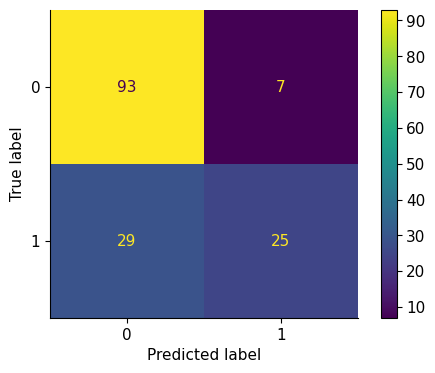

In [ ]:
# TODO: Train/test split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9400)

# TODO: Define the baseline pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=9400))])

# TODO: Fit and evaluate
pipeline.fit(xtrain, ytrain)
#print("Model coefficients: ", pipeline.coef_, pipeline.intercept_)
y_pred = pipeline.predict(xtest)
y_train_pred = pipeline.predict(xtrain)


# TODO: Report training and test accuracy
training_acc = np.mean(y_train_pred == ytrain)
testing_acc = np.mean(y_pred == ytest)
# train_acc = pipeline.score(xtrain, ytrain)
# test_acc = pipeline.score(xtest, ytest)
print(f"Training accuracy: {training_acc:.3f}")
print(f"Test accuracy: {testing_acc:.3f}")

# TODO: Plot Confusion matrix on test set
# cm = np.zeros((2,2))
# for i in range(len(y_pred)):
#     cm[y_pred[i], ytest[i]] += 1

# import seaborn as sns
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

cm = confusion_matrix(ytest, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()


### Short Answer

- Compare training vs test accuracy.
- Does the model appear to overfit, underfit, or behave reasonably? Explain briefly.

> TODO: Write your answer here.

a - The training accuracy is of course higher than the testing accuracy, which is expected. It is much less of a discrepancy than I expected. I always imagined that any function fitted to an input will always match that input in output.

b - I beleive it is a generally good fit. The accuracy is not too low, but the training accuracy is not way higher than the testing accuracy.

---
## 4. Task 3 – Effect of Regularization Strength C (25 pts)

**Goal:** Use cross-validation to choose the L2 regularization strength.

### Instructions
- Use a `Pipeline` with `StandardScaler` + `LogisticRegression(penalty='l2')`.
- Use `StratifiedKFold(n_splits=5, shuffle=True, random_state=9400)`.
- Search `C ∈ {1e-3, 1e-2, 1e-1, 1, 10, 100}` with `GridSearchCV`.
- For each C, record mean CV accuracy.
- Plot mean CV accuracy vs `log10(C)`.
- Refit the best model on the full training set and evaluate on the test set.


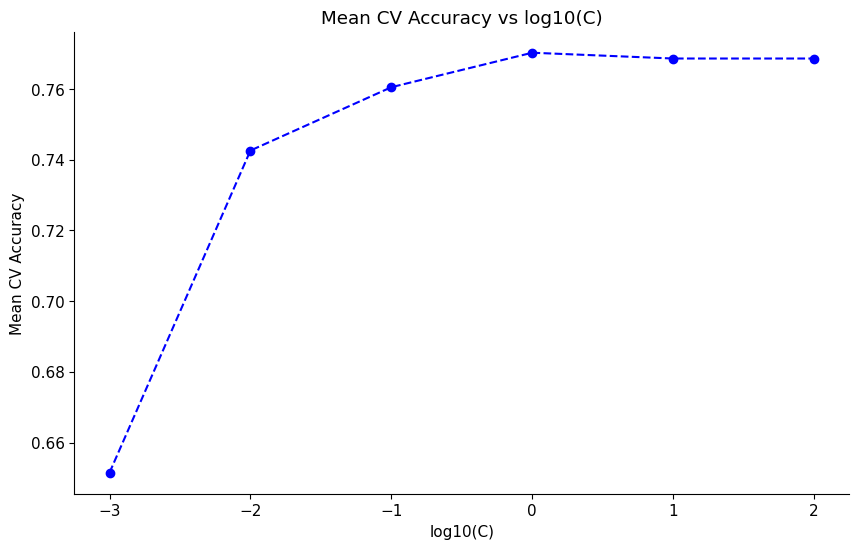

[[ 0.41174485  1.09240961 -0.2756068   0.02299284 -0.15444236  0.68541628
   0.25001117  0.24979633]]
Best estimator: {'logreg__C': 1}
Best testing accuracy: 0.766
Number of non-zero coefficients: 8


In [47]:
# TODO: Define grid of C values
c_grid = [1e-3, 1e-2, 1e-1, 1, 10, 100]

# TODO: Create pipeline for L2-regularized logistic regression
new_pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=9400))])
# TODO: Search over grid of C parameters 
grid_search = GridSearchCV(new_pipeline, param_grid={'logreg__C': c_grid}, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=9400), scoring='accuracy')
grid_search.fit(xtrain, ytrain)
## TODO: For each C, record mean CV accuracy
cv_results = grid_search.cv_results_
mean_cv_accuracy = cv_results['mean_test_score']
log10_c = np.log10(c_grid)

## TODO: Plot mean CV accuracy vs log10(C)
plt.figure(figsize=(10, 6))
plt.plot(log10_c, mean_cv_accuracy, marker='o', linestyle='--', color='b')
plt.xlabel('log10(C)')
plt.ylabel('Mean CV Accuracy')
plt.title('Mean CV Accuracy vs log10(C)')
plt.show()


## TODO: Refit best model on full training set & evaluate on test set
#find the index of the best mean cv accuracy
# best_index = np.argmax(mean_cv_accuracy)
# best_c = c_grid[best_index]
best_model = grid_search.best_estimator_
best_model.fit(xtrain, ytrain)
best_y_pred = best_model.predict(xtest)
best_testing_acc = np.mean(best_y_pred == ytest)
print(best_model.named_steps['logreg'].coef_)
print(f"Best estimator: {grid_search.best_params_}")
print(f"Best testing accuracy: {best_testing_acc:.3f}")
print(f"Number of non-zero coefficients: {count_nonzero_coefs(best_model)}")



### Short Answer

- How does C influence cross-validated performance?
- What happens for very small vs very large C?
- Which C do you choose, and why?

> TODO: Write your answer here.

a - a smaller c leads to less regularization, which is correlated to a lower accuracy. Less regularization causes features that exist withing smaller value ranges to have less influence, with higher value features dominating the model.

b - A small C caused an inaccurate model, while a very high c led to a model almost as accurate as the best c value.

c - I chose a C value of 1, because it happened to be the highest accuracy parameter for my model and data.

---
## 5. Task 4 – L1 regularized logistic regression (25 points)

### Instructions
- Fit an L1-penalized model (`penalty='l1'`, `solver='liblinear'`) with GridSearchCV over the same C grid.
- For the best model, report:
  - Best hyperparameters
  - Test accuracy
  - Number of non-zero coefficients


In [48]:
# Helper: count non-zero coefficients in a Pipeline(LogisticRegression)
def count_nonzero_coefs(pipe_model):
    logreg = pipe_model.named_steps['logreg']
    return np.sum(logreg.coef_ != 0)

# L2 summary (reuse best_model)
l2_nonzero = count_nonzero_coefs(best_model)
l2_test_acc = accuracy_score(ytest, best_model.predict(xtest))
print(f'[L2] best C={best_model.named_steps["logreg"].C}, '
      f'non-zero coeffs={l2_nonzero}, test acc={l2_test_acc:.3f}')

[L2] best C=1, non-zero coeffs=8, test acc=0.766


In [ ]:
# TODO:  redefine grid of C values
c_grid = [1e-3, 1e-2, 1e-1, 1, 10, 100]  #md says same c grid
# TODO: Create pipeline for L1-penalized logistic regression
L1_pipeline = Pipeline([]

# TODO: fit pipeline and find best C value, measure test accuracy and number of non-zero coefficients


[[ 0.4067714   1.08392163 -0.25898096  0.00333319 -0.13790366  0.67667132
   0.24150806  0.23823666]]
Best C: 1.000
Test accuracy: 0.766
Number of non-zero coefficients: 8


### Short Answer

- Which penalty produced the sparsest model (fewest non-zero coefficients)?
- How do test accuracies compare between L2 and L1?
- If two models have similar accuracy but different sparsity, which would you prefer here, and why?

> TODO: Write your answer here.


a - Both my L1 and L2 models produced the same numebr of nonzero coefficients.

b - The test accuracies are both exactly the same ( down to 3 sf)

c - Well the two models had equal accuracy and sparcity, but I would pick equal sparcity if given the choice.

---
## 6. Task 5 – Probabilities, ROC Curve & Thresholds (20 pts)

**Goal:** Use logistic regression calibration to study trade-offs between sensitivity and specificity.

### Instructions
- Using your **best L2 model**, compute predicted probabilities `P(Outcome=1)` on `X_test`.
- Compute **ROC AUC** and plot the ROC curve.
- Choose a threshold different from 0.5 (e.g., 0.4) and:
  - Compute accuracy.
  - Show the confusion matrix.


In [ ]:
# TODO: Compute predicted probabilities for the positive class using the best L2 model
y_predicted_probs = best_model.predict_proba(xtest)[:, 1]


# TODO: plot ROC curve and compute the area under the curve (AUC)
# Hint: use sklearn.metrics.roc_curve and sklearn.metrics.roc_auc_score


In [ ]:
# TODO: Using a threshold of 0.4, compute accuracy and show confusion matrix


### Short Answer

- How does lowering the threshold (e.g., from 0.5 to 0.4) affect false negatives vs false positives?
- For a diabetes screening scenario, would you choose a higher or lower threshold than 0.5? Explain.

> TODO: Write your answer here.
